In [1]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [2]:
%matplotlib inline

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
 # TODO is this line still needed?
lmtest = importr('lmtest')
# https://stackoverflow.com/questions/32983365/rpy2-cannot-find-installed-external-r-packages
Hmisc = importr("Hmisc")
pandas2ri.activate()

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [3]:
# stat functions
def run_r_corr(df, corr_type='spearman', p_correction='BH'):
    """
    Runs R correlation calculations and p-value corrections on the given dataframe.
    
    :returns: a tuple of (correlations, counts, p_values)
    """
    num_cols = len(df.columns.values)
    r_dataframe = pandas2ri.py2ri(df)
    r_as = r['as.matrix']
    rcorr = r['rcorr'] 
    r_p_adjust = r['p.adjust']
    result = rcorr(r_as(r_dataframe), type=corr_type)
    rho = result[0]
    n = result[1]
    p = result[2]
    
    if p_correction is not None:
        p = r_p_adjust(p, p_correction)
    r_corrs = pandas2ri.ri2py(rho)
    r_p_vals = pandas2ri.ri2py(p)
    r_counts = pandas2ri.ri2py(n)
    r_p_vals = np.reshape(r_p_vals, (num_cols,num_cols))
    return r_corrs, r_counts, r_p_vals

def build_corr_mat(corrs, p_vals, labels, title, alpha):
    """
    returns the matplotlib plt object for the specified correlations.
    """
    plt.rcParams["figure.figsize"] = [20,12]
    plt.imshow(corrs)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = "{0:.2f}".format(r_corrs[i, j])
            p = p_vals[i,j]
            if p < alpha / len(labels):
                text = text + "*"
            plt.text(j,i, text, ha="center", va="center", color="w")
    plt.xticks([x for x in range(len(labels))], labels, rotation=45, ha="right", rotation_mode='anchor')
    plt.yticks([x for x in range(len(labels))], labels)
    plt.colorbar()
    plt.title(title)
    return plt


In [179]:
def build_lowess_plot(features, x_col, y_col, it=4):
    
    
    
    groups = {
        'all': ['family_live_together', 'family_live_separate', 'friend', 'work', 'task', 'sig_other'],
        'social': ['family_live_separate', 'friend'],
        'work': ['work'],
        'family_together': ['family_live_together', 'sig_other'],
        'task': ['task']
#         'friend': ['friend'],
#         'work': ['work'],
#         'family_live_together': ['family_live_together'],
#         'sig_other': ['sig_other'],
#         'family_live_separate': ['family_live_separate'],
#         'task': ['task']
    }

    for label, contact_types in groups.items():
        df = features.loc[ag_features['contact_type'].isin(contact_types)]

        x = df[x_col]
        y = df[y_col]

        filtered = lowess(y, x, return_sorted=True, frac=0.66, it=it)
        plt.plot(filtered[:, 0], filtered[:, 1], label=label)
    
    plt.legend()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title("LOWESS of {} as a function of {}".format(y_col, x_col))
    plt.show()

# Demographics feature analysis

## Updated abstract

Estimating the nature and quality of interpersonal relationships from phone data could be useful for studies of mental well-being and social support. Prior works utilized the volume of communications to estimate broad relationship categories. In this paper, we contextualize communication events by combining phone logs with demographic and location data to predict social roles as well as relationship qualities such as closeness. We obtain the most benefit in model performance by including participant age, which is not an additive factor but rather an interaction with communication trends across social roles. Our findings not only illustrate the value of utilizing data across different modalities, but also underscore the importance of considering population heterogeneity in phone-based mental health studies.

In [263]:
# load age-based features
#with open("../data/final_features/all_contacts_age_gender_dedup_nan_train_features.df", "rb") as f:
#with open("../data/final_features/top10_all_dedup_nan_train_features.df", "rb") as f:
with open("../data/final_features_jan28/top_5_age_gender_train_features.df", "rb") as f:
    ag_features = pickle.load(f)

## Age descriptive statistics

- we see that age is roughly normally distributed, and unsurpisingly there is  no direct relationship between age and social contacts

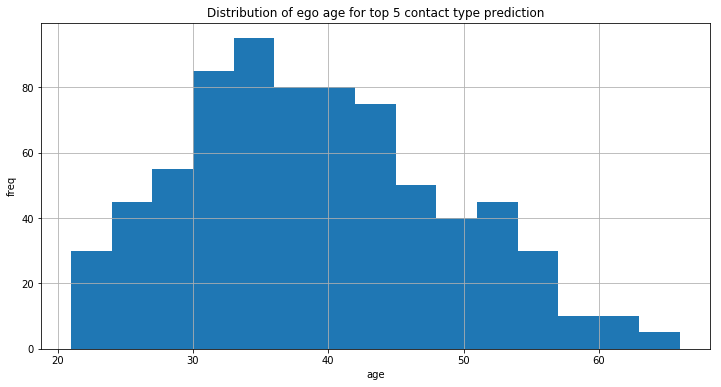

In [281]:
ag_features['ego_age'].hist(bins=15)
plt.ylabel("freq")
plt.xlabel("age")
plt.title("Distribution of ego age for top 5 contact type prediction")
plt.show()

In [264]:
ag_features['ego_age'].describe()

count    735.000000
mean      38.564626
std        9.642145
min       21.000000
25%       31.000000
50%       38.000000
75%       46.000000
max       66.000000
Name: ego_age, dtype: float64

In [265]:
screener_df = pd.read_csv('../CS120/CS120Clinical/CS120Final_Screener.csv', encoding = "ISO-8859-1")
screener_df['pid'] = screener_df['ID']
phq_dict = pd.Series(screener_df['score_PHQ'].values, index=screener_df['pid']).to_dict()
gad_dict = pd.Series(screener_df['score_GAD'].values, index=screener_df['pid']).to_dict()

In [266]:
ag_features['ego_phq'] = ag_features['pid'].map(phq_dict)
ag_features['ego_gad'] = ag_features['pid'].map(gad_dict)

In [267]:
# with open("../data/final_features/top10_age_gender_dedup_nan_test_features.df", "rb") as f:
#     test_ag_features = pickle.load(f)

# test_ag_features.drop_duplicates("pid"['ego_age'].describe()

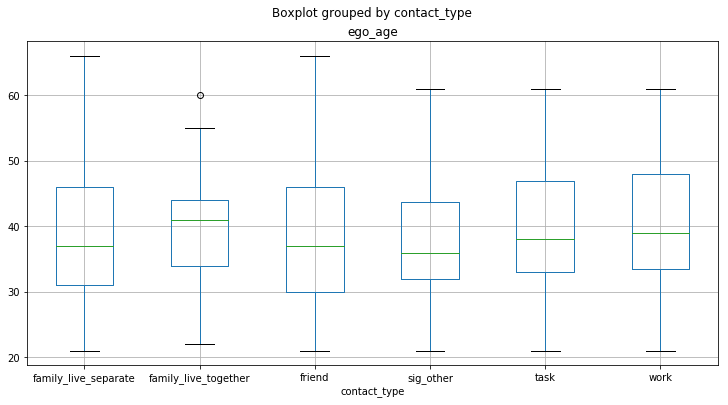

In [278]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_age', by='contact_type')
plt.show()

## Performance increase when including age/gender

- however, we see the largest increase in test performance when including age and gender, with little further improvement when including other demographics or location-based features

- **Note**: 5-fold CV results show the only performance bump with age/gender, though much smaller from over baseline (66% acc to 68.5% acc)

![](../tex/figures/top5_collapsed_f1_test.png)

## Feature importance using SHAP

[SHAP reference](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)

- we see that time of day call and text frequency are the most important features
- overall comunication volume is also important (total_comm_days, total_comms)

![](../tex/figures/age_gender_shap.png)

## Age analysis in the context of communication features

In [269]:
corr_df = ag_features.drop(labels=['pid','combined_hash', 'contact_type'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')
alpha = 0.01
# plt = build_corr_mat(r_corrs, 
#                      r_p_vals, 
#                      corr_df.columns.values, 
#                      "Across subject pearson correlations, significance* at FDR<{}".format(alpha),
#                      alpha)
# plt.show()

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))


In [270]:
cols = corr_df.columns.values
age_idx = np.where(cols=='ego_age')

### significant correlations (p < 0.05), Benjamini-Hochberg corrected

- some of the time of day, day of week communication features are significantly correlated with age

In [276]:
age_corrs = r_corrs[age_idx]
age_p_vals = r_p_vals[age_idx]

age_stats = np.transpose(np.vstack((age_corrs, age_p_vals)))
age_df = pd.DataFrame(age_stats, index=cols, columns=['corr', 'p'])
sig_features = age_df.loc[age_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.str.startswith("ego")]
sig_features = sig_features.loc[~sig_features.index.str.endswith("indicator")]

sig_features.sort_values(by='corr')
#sig_features.shape

,corr,p
time_of_day_0_sms,-0.159501,0.000036
day_6_sms,-0.144346,0.000213
reg_sms,-0.122905,0.001742
std_in_sms,-0.118806,0.002527
time_of_day_5_sms,-0.116507,0.003125
total_sms_days,-0.112331,0.004498
mean_in_sms,-0.102024,0.010496
med_out_sms,-0.102010,0.010507
std_out_sms,-0.100914,0.011469
max_in_sms,-0.097736,0.014605


In [272]:
age_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

,corr,p
q1_want,-0.021972,0.635000
q2_talk,-0.084653,0.037394
q3_loan,-0.081666,0.045218
q4_closeness,-0.062887,0.133810


## LOWESS

- however, if we analyze the distribution of temporal features as a function of age across the different contact types, we see large variations in trends 

### Night (8pm - 12am) texts
- most important temporal feature, according to SHAP analysis
- Though the overall trend is downward (see "all" line in blue), there are large variations in trends across contact types within our population
- overall trend: the older you are, the less frequent texts at night are
- however, only "task" and "social" contacty types correctly track this trend
- **TODO**: need some sort of error/uncertainty bound for LOWESS plots

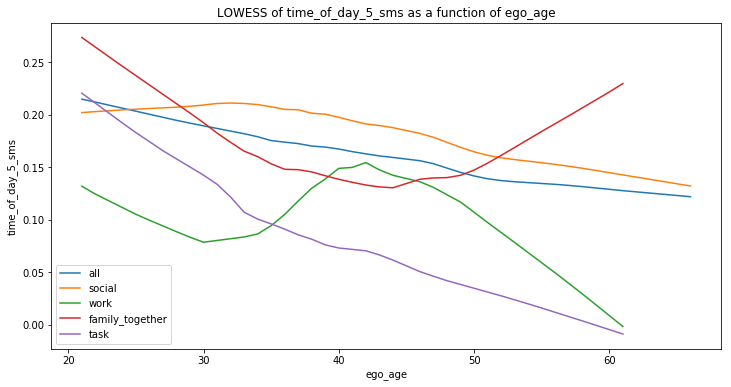

In [284]:
build_lowess_plot(ag_features, "ego_age", "time_of_day_5_sms", it=0)

### Late morning (8 am - 12 pm) calls

- second-most important temporal communication feature
- less divergence in distribution across the different contact types other than task

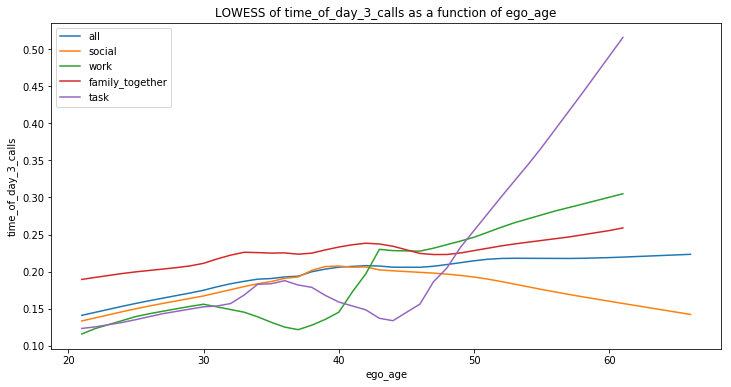

In [288]:
build_lowess_plot(ag_features, "ego_age", "time_of_day_3_calls", it=0)

### Night (8pm - 12 am) calls

- again we see variation in the distribution of this feature across contact types, with family_together contacts remaining stable across all age brackets while others follow a general downward trend

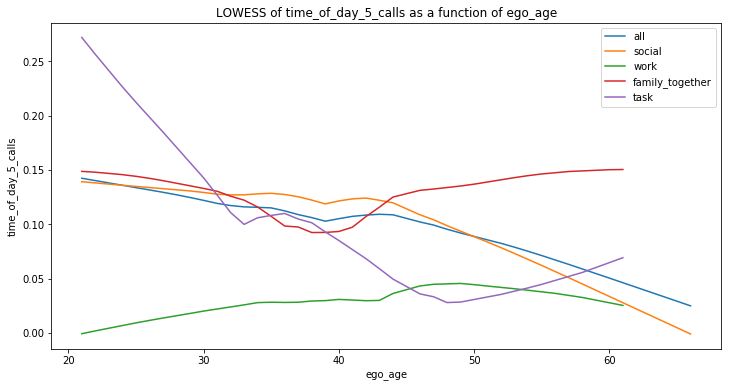

In [291]:
build_lowess_plot(ag_features, "ego_age", "time_of_day_5_calls", it=0)

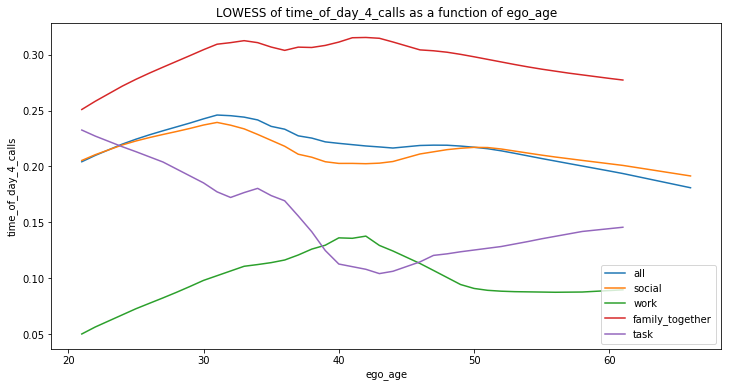

In [295]:
build_lowess_plot(ag_features, "ego_age", "time_of_day_4_calls", it=1)

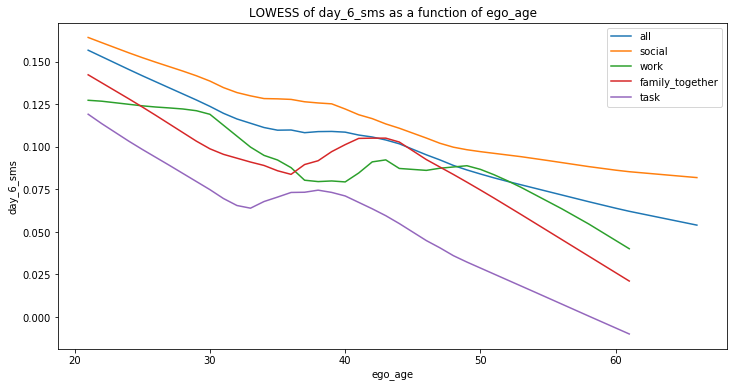

In [297]:
build_lowess_plot(ag_features, "ego_age", "day_6_sms", it=0)

## EMC results

- in contrast, we largely see agreement in EMC responses for different contact types, regardless of age
- this is unsurprising as these qualitative measures should not vary too much across age groups

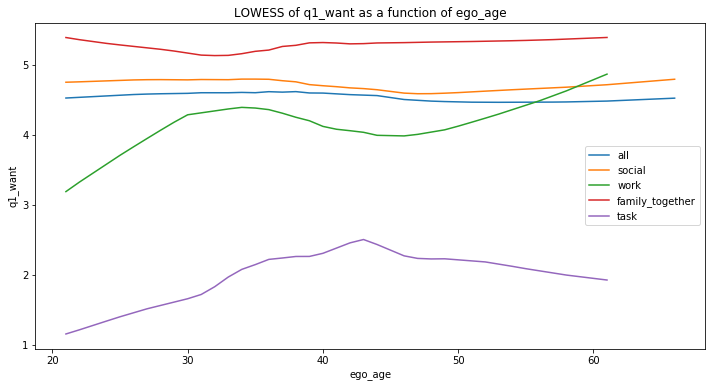

In [298]:
build_lowess_plot(ag_features, "ego_age", 'q1_want', it=0)

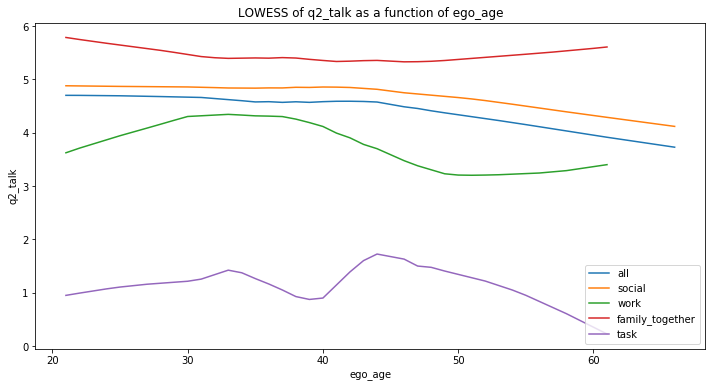

In [299]:
build_lowess_plot(ag_features, "ego_age", 'q2_talk', it=0)

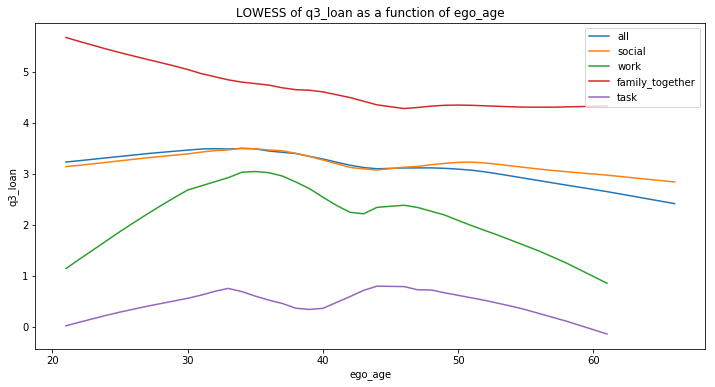

In [300]:
build_lowess_plot(ag_features, "ego_age", 'q3_loan', it=0)

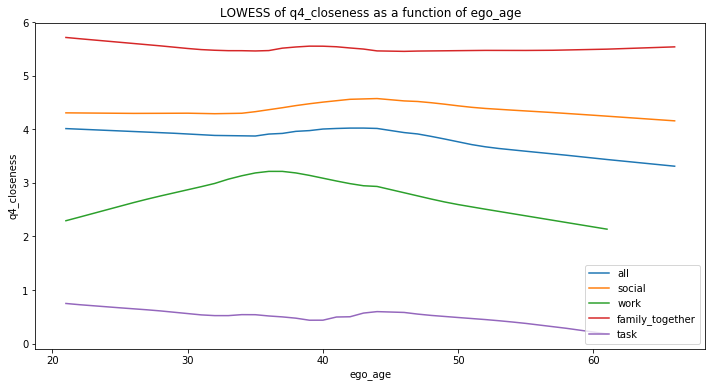

In [186]:
build_lowess_plot(ag_features, "ego_age", 'q4_closeness', it=0)

## Additional exploratory work

**note**: these analyses probably won't be used for MobiCom

## PHQ

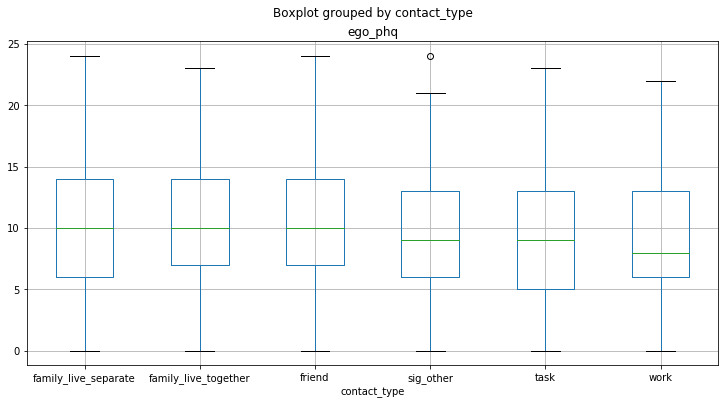

In [137]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_phq', by='contact_type')

In [138]:
corr_df = ag_features.drop(labels=['pid','combined_hash', 'contact_type'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')
alpha = 0.01
# plt = build_corr_mat(r_corrs, 
#                      r_p_vals, 
#                      corr_df.columns.values, 
#                      "Across subject pearson correlations, significance* at FDR<{}".format(alpha),
#                      alpha)
# plt.show()

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/sit

In [142]:
cols = corr_df.columns.values
phq_idx = np.where(cols=='ego_phq')

In [143]:
phq_corrs = r_corrs[phq_idx]
phq_p_vals = r_p_vals[phq_idx]

phq_stats = np.transpose(np.vstack((phq_corrs, phq_p_vals)))
phq_df = pd.DataFrame(phq_stats, index=cols, columns=['corr', 'p'])
phq_df.loc[phq_df['p'] < 0.01].sort_values(by='corr')

,corr,p
ego_age,-0.181440,2.255230e-11
ego_race_prefer_no_answer,-0.142986,2.613878e-07
ego_race_amer_indian,-0.114334,6.201049e-05
ego_live_together_>=3_others,-0.107421,1.937481e-04
ego_employment_employed,-0.105311,2.699058e-04
all_sms_visit_reason:entertainment,-0.104430,3.092183e-04
all_call_visit_reason:entertainment,-0.102956,3.879200e-04
ego_education_associates,-0.089392,2.658748e-03
ego_race_white,-0.084941,4.707477e-03
std_out_sms,0.081167,7.475686e-03


### EMC correlations

In [144]:
phq_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

,corr,p
q1_want,-0.045807,0.196405
q2_talk,0.001959,0.976044
q3_loan,-0.047331,0.176872
q4_closeness,-0.003663,0.956256


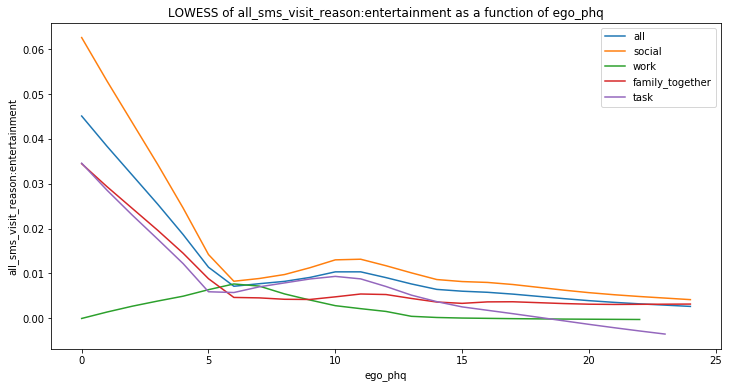

In [156]:
build_lowess_plot(ag_features, "ego_phq", "all_sms_visit_reason:entertainment", it=0)

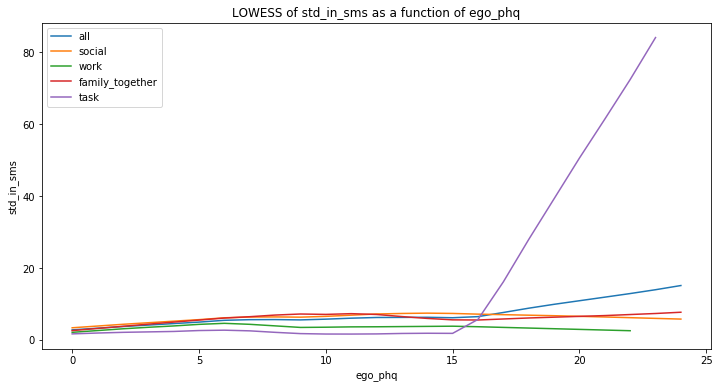

In [188]:
build_lowess_plot(ag_features, "ego_phq", "std_in_sms", it=0)

## GAD

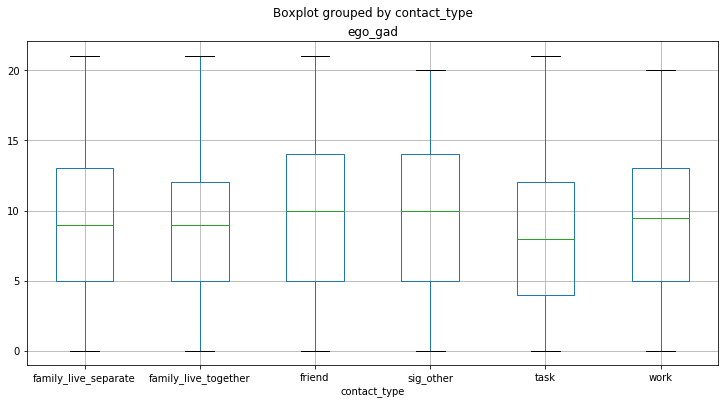

In [146]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_gad', by='contact_type')

In [148]:
cols = corr_df.columns.values
gad_idx = np.where(cols=='ego_gad')

In [149]:
gad_corrs = r_corrs[gad_idx]
gad_p_vals = r_p_vals[gad_idx]

gad_stats = np.transpose(np.vstack((gad_corrs, gad_p_vals)))
gad_df = pd.DataFrame(gad_stats, index=cols, columns=['corr', 'p'])
gad_df.loc[gad_df['p'] < 0.01].sort_values(by='corr')

,corr,p
ego_gender_other,-0.148966,7.097525e-08
ego_employment_retired,-0.148966,7.097525e-08
ego_age,-0.143515,2.334670e-07
ego_employment_disability,-0.128207,5.158919e-06
ego_education_some_hs,-0.125086,9.227043e-06
all_call_visit_reason:exercise,-0.099650,6.350129e-04
max_out_duration,-0.091058,2.127943e-03
all_call_visit_reason:entertainment,-0.089556,2.600673e-03
ego_race_white,-0.081841,6.893382e-03
avg_out_duration,-0.081000,7.620675e-03


In [150]:
gad_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

,corr,p
q1_want,0.002506,0.969676
q2_talk,0.085771,0.004239
q3_loan,0.053408,0.113518
q4_closeness,0.067669,0.032434


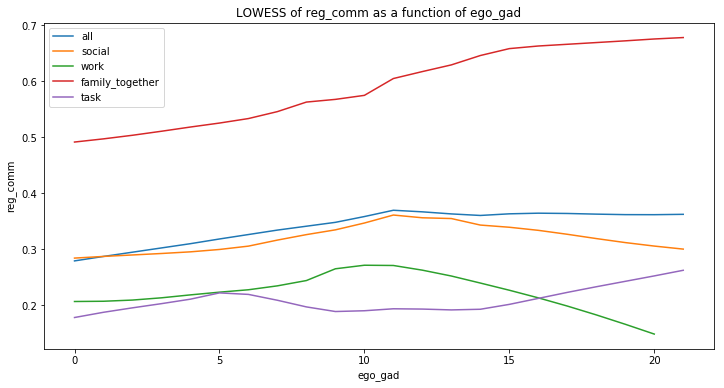

In [189]:
build_lowess_plot(ag_features, "ego_gad", "reg_comm", it=0)

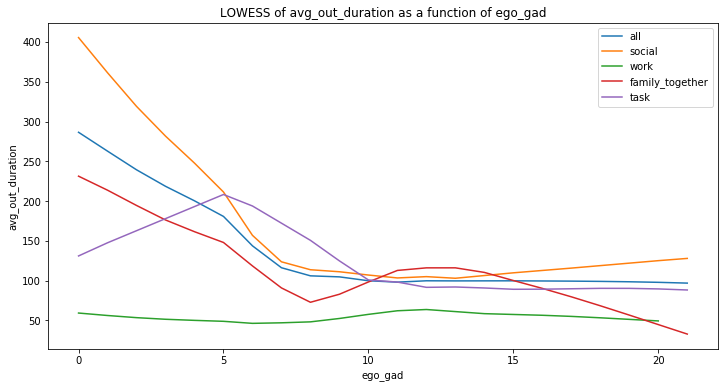

In [175]:
build_lowess_plot(ag_features, "ego_gad", "avg_out_duration", it=0)

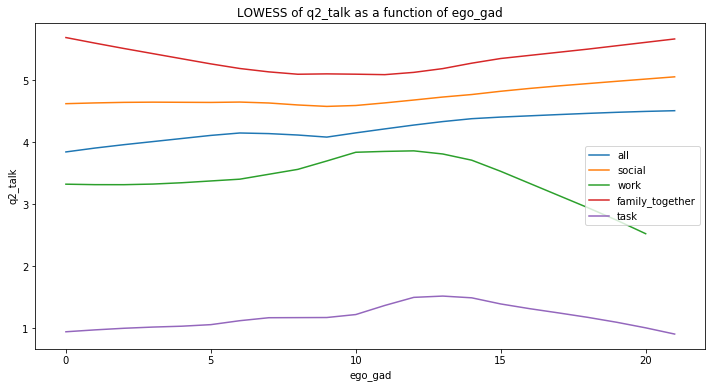

In [159]:
build_lowess_plot(ag_features, "ego_gad", "q2_talk", it=0)

### Notes

- as age increases:
    - willingness for communication increases
    - willingness to talk about importance matters decreases
    - willingness to ask for loans decreases
    - duration of call duration increases
    - tendency to call over text increases
    - less communication on Saturday
    - less texts in the evening
    
- argument: people of different age groups communicate with their friends, family differently